# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Step 1 - Data Understanding
### (A) Portfolio Data

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

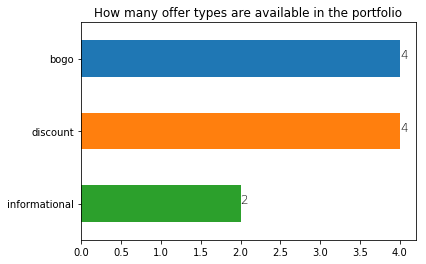

In [8]:
# Although being a very small dataset, I still find it helpful to visualize what can be visualized in order to increase data unterstanding
def horizontal_bar_plot(df, colName, pltTitle, bInvertYAxis=True, fntSize=12, fntWeight=12):
    plt.figure(figsize=(20, 5))
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)
horizontal_bar_plot(portfolio, 'offer_type', "How many offer types are available in the portfolio")

### (B) Profile Data

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.shape

(17000, 5)

In [11]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [14]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
# It looks like the NULL values in Gender and Income come from the Age = 118 rows.
profile.age.value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

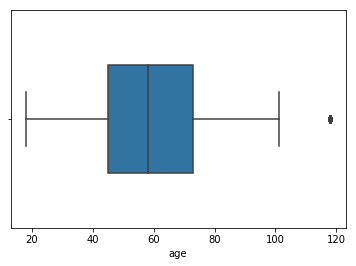

In [16]:
# The Boxplot also shows that these people can be considered outliers => let's keep in in mind for potential cleaning steps.
sns.boxplot(profile['age'], width=0.5);

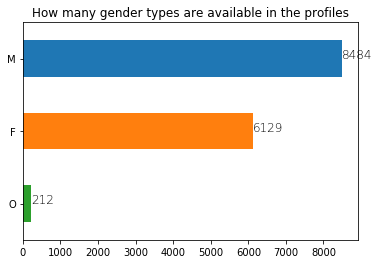

In [17]:
horizontal_bar_plot(profile, 'gender', "How many gender types are available in the profiles")

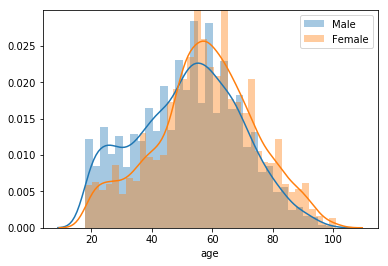

In [18]:
# Women in our dataset have an older age strucutre / distribution than men.
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
plt.legend()
plt.show()

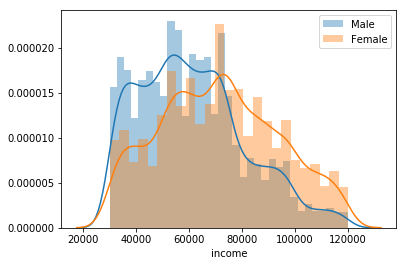

In [19]:
# Women in our dataset have a more evenly distributed income than men.
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

### (C) Transcript Data

In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
transcript.shape

(306534, 4)

In [22]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [25]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

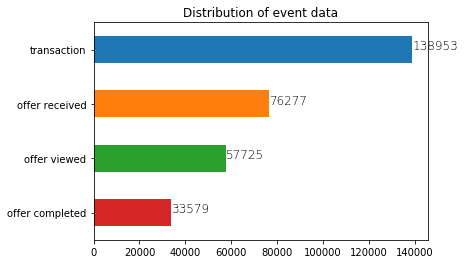

In [26]:
# Let's have a look at the number of events in a bar chart.
horizontal_bar_plot(transcript, 'event', "Distribution of event data")

## Step 2 - Data Cleaning
### (A) Portfolio Data

In [27]:
# The Portfolio data is more or less clean enough.
# Nontheless, let's improve the readability by renaming the columns.

def rename_cols(df, cols_name_new):
    df= df.rename(columns = cols_name_new)
    return df

In [28]:
# cols_name_new = {'difficulty':'portfolio_difficulty', 'id':'portfolio_id', 'duration':'portfolio_duration', 'reward':'portfolio_reward'}
# portfolio_clean = rename_cols(portfolio, cols_name_new)
# portfolio_clean()

# First I wanted to rename the columns in way that they show their dataset origin (s. above).
# I think, however that using the word "offer" will better match their meaning, therefore:

cols_name_new = {'difficulty':'offer_difficulty', 'id':'offer_id', 'duration':'offer_duration', 'reward':'offer_reward'}
portfolio_clean = rename_cols(portfolio, cols_name_new)
portfolio_clean.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


### (B) Profile Data

In [29]:
# First, let's rename the columns to match what we did with the portfolio data

cols_name_new = {'id':'customer_id' , 'income':'customer_income'}
profile_clean = rename_cols(profile, cols_name_new)
profile_clean.head()

,age,became_member_on,gender,customer_id,customer_income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [30]:
# Next, let's covert the became_member_on values in real timestamps
profile_clean.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")
type(profile_clean.became_member_on[0])

pandas._libs.tslibs.timestamps.Timestamp

In [31]:
# Finally, after dealing with namings and dtypes, we need to address some data issues.

# 1. I decieded on changing the 118 age entries to NaN and afterwards to the overall mean ages, in order to lose less data (as compared to deleting it)
# 2. We will then have to replace the missing incomes with the mean incomes as well.
# 3. I will do the same with gender, meaning I will change all NaN values with the mode (most frequent gender)
# 4. I do not think the detailed age is relevant, therefore I will create age brackets, a procedure that we use in our daily business as well.

def profile_cleaning(df):
    
    # 1.
    df.replace(118, np.nan , inplace=True)
    df['age'] = df['age'].fillna(df['age'].mean())
    
    # 2.
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    
    # 3.
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    # 4.
    df.loc[(df.age < 21) , 'age_group'] = '0-20'
    df.loc[(df.age >= 21) & (df.age <= 30) , 'age_group'] = '21-30'
    df.loc[(df.age >= 31) & (df.age <= 40) , 'age_group'] = '31-40'
    df.loc[(df.age >= 41) & (df.age <= 50) , 'age_group'] = '41-50'
    df.loc[(df.age >= 51) & (df.age <= 60) , 'age_group'] = '51-60'
    df.loc[(df.age >= 61) & (df.age <= 70) , 'age_group'] = '61-70'
    df.loc[(df.age >= 71) & (df.age <= 80) , 'age_group'] = '71-80'
    df.loc[(df.age >= 81) , 'age_group'] = '> 80'
    df.drop('age',axis=1,inplace=True)
   
    return df

In [32]:
profile_clean = profile_cleaning(profile_clean)
profile_clean.head()

,became_member_on,gender,customer_id,customer_income,age_group
0,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,51-60
1,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,51-60
2,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,51-60
3,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,71-80
4,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,51-60


In [33]:
# During the EDA part (in the lower part of this notebook) I came across the need to have the year and month of start of membership seperately. therefore:
profile_clean['membership_year'] = profile_clean.became_member_on.dt.year
profile_clean['membership_month'] = profile_clean.became_member_on.dt.month
profile_clean.head()

,became_member_on,gender,customer_id,customer_income,age_group,membership_year,membership_month
0,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,51-60,2017,2
1,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,51-60,2017,7
2,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,51-60,2018,7
3,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,71-80,2017,5
4,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,51-60,2017,8


In [34]:
# Let's check whether we got all the NULL values
profile_clean.isnull().sum()

became_member_on    0
gender              0
customer_id         0
customer_income     0
age_group           0
membership_year     0
membership_month    0
dtype: int64

In [35]:
profile_clean.dtypes

became_member_on    datetime64[ns]
gender                      object
customer_id                 object
customer_income            float64
age_group                   object
membership_year              int64
membership_month             int64
dtype: object

### (C) Transcript Data

In [36]:
# Here we also need to rename a column to improve dataset understandability.
cols_name_new = {'person':'customer_id'}
transcript_clean = rename_cols(transcript, cols_name_new)
transcript_clean.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [37]:
# Since the value column can hold information about the offer id or a transaction amount, we need to address that by splitting the content into three columns

def transcript_cleaning(df):
        
    # We need to extend the dict and already account for the correct naming of "offer_id"
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['reward_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['amount_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    # Now we can move the values of "offer id" to the "offer_id" column / drop the column and deal with NaN
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    df.fillna(0 , inplace=True)
    
    return df

In [38]:
transcript_clean = transcript_cleaning(transcript_clean)
transcript_clean.head()

,event,customer_id,time,offer_id,reward_gained,amount_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


### (D) Re-check Data

In [39]:
portfolio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels            10 non-null object
offer_difficulty    10 non-null int64
offer_duration      10 non-null int64
offer_id            10 non-null object
offer_type          10 non-null object
offer_reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [40]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
became_member_on    17000 non-null datetime64[ns]
gender              17000 non-null object
customer_id         17000 non-null object
customer_income     17000 non-null float64
age_group           17000 non-null object
membership_year     17000 non-null int64
membership_month    17000 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 929.8+ KB


In [41]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event            306534 non-null object
customer_id      306534 non-null object
time             306534 non-null int64
offer_id         306534 non-null object
reward_gained    306534 non-null float64
amount_spent     306534 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


## Step 3 - EDA
### (A) One DataFrame

In [42]:
# Before going into the Exploratory Data Analysis, we need to combine / merge the seperate dataframes

def dataframe_merging(portfolio,profile,transcript):
    
    # After renaming the columns in the previous steps, we can easily merge the dfs. 
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [43]:
merged_data = dataframe_merging(portfolio_clean, profile_clean, transcript_clean)
merged_data.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,reward_gained,amount_spent,became_member_on,gender,customer_income,age_group,membership_year,membership_month
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,2017-09-09,M,100000.0,61-70,2017,9
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,2017-09-09,M,100000.0,61-70,2017,9
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,2017-09-09,M,100000.0,61-70,2017,9
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,2017-09-09,M,100000.0,61-70,2017,9
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,2017-09-09,M,100000.0,61-70,2017,9


In [44]:
# The merged dataframe looks good, now we can start with the EDA
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 17 columns):
channels            167581 non-null object
offer_difficulty    167581 non-null int64
offer_duration      167581 non-null int64
offer_id            167581 non-null object
offer_type          167581 non-null object
offer_reward        167581 non-null int64
event               167581 non-null object
customer_id         167581 non-null object
time                167581 non-null int64
reward_gained       167581 non-null float64
amount_spent        167581 non-null float64
became_member_on    167581 non-null datetime64[ns]
gender              167581 non-null object
customer_income     167581 non-null float64
age_group           167581 non-null object
membership_year     167581 non-null int64
membership_month    167581 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(7)
memory usage: 23.0+ MB


### (B) What is the averge income?

In [45]:
merged_data['customer_income'].mean()

66301.05514161117

In [46]:
merged_data['customer_income'].describe()

count    167581.000000
mean      66301.055142
std       20259.401992
min       30000.000000
25%       52000.000000
50%       65404.991568
75%       78000.000000
max      120000.000000
Name: customer_income, dtype: float64

Text(0.5,0,'Income')

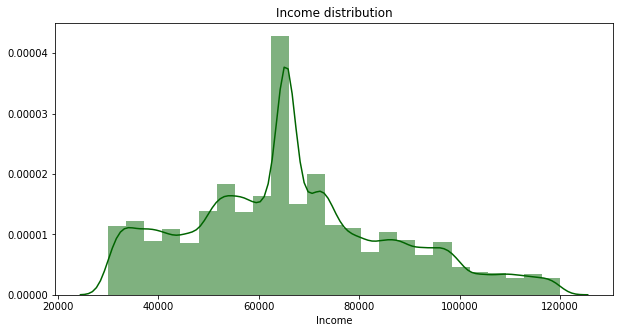

In [47]:
plt.figure(figsize=(10, 5))
sns.distplot(merged_data['customer_income'], bins=25, color="darkgreen", hist_kws={'alpha': 0.5});
plt.title('Income distribution')
plt.xlabel('Income')

### FINDINGS
=> The average income is **66301**  
=> The median income is **65405**  
=> We can not observe a normal distribution  
=> Most incomes range between **52k and 78k**  

### (C) What do we know about age and gender distribution?

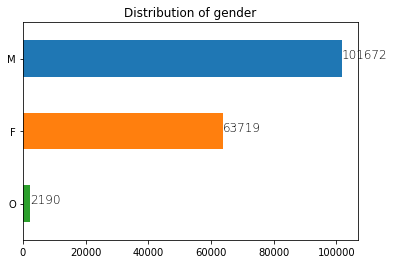

In [48]:
horizontal_bar_plot(merged_data, 'gender', "Distribution of gender")

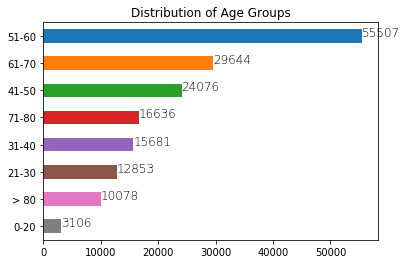

In [49]:
horizontal_bar_plot(merged_data, 'age_group', "Distribution of Age Groups")

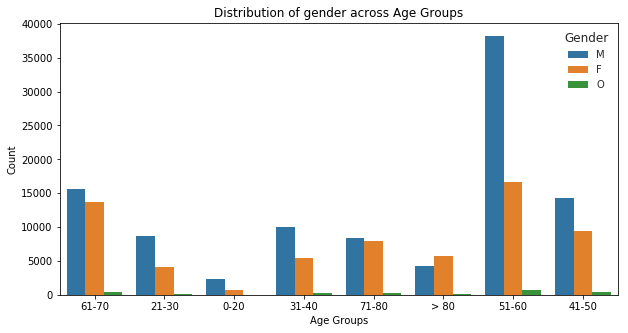

In [50]:
plt.figure(figsize=(10, 5))
sns.countplot(x = 'age_group', hue = 'gender', data = merged_data)
sns.set(style="whitegrid")
plt.title('Distribution of gender across Age Groups')
plt.ylabel('Count')
plt.xlabel('Age Groups')
plt.legend(title='Gender')

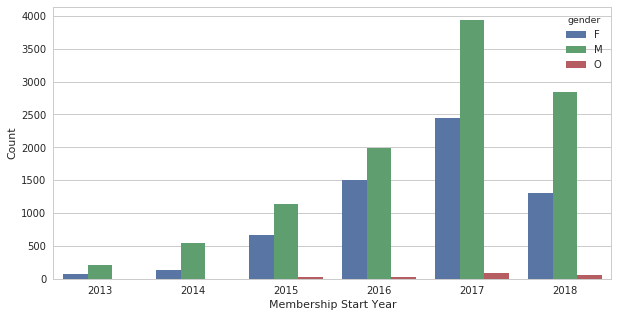

In [51]:
# Let's group the membership starts by year and gender
membership_date = profile_clean.groupby(['membership_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['membership_year', 'gender', 'count']

plt.figure(figsize=(10, 5))
sns.barplot(x='membership_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

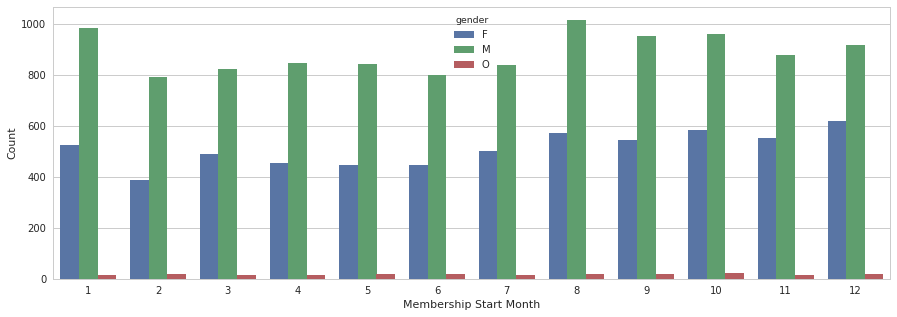

In [52]:
# Let's group the membership starts by month and gender
membership_date = profile_clean.groupby(['membership_month', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['membership_month', 'gender', 'count']

plt.figure(figsize=(15, 5))
sns.barplot(x='membership_month', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Month')
plt.ylabel('Count');

### FINDINGS
=> The dataset contains almost **40k** more men than women  
=> Most members are between **51** and **60**, with **61** to **70** being in second place   
=> The biggest membership group according to age (51-60) is dominated by **male** members  
=> Most new memberships were signed in **2017** followed by **2018** with a overrepresentation of male members   
=> Most new memberships were signed in **January & August through October**  

### (D) What do we know about the offers in combination with prior investigatons?

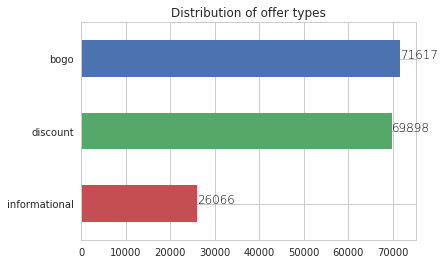

In [53]:
horizontal_bar_plot(merged_data, 'offer_type', "Distribution of offer types")

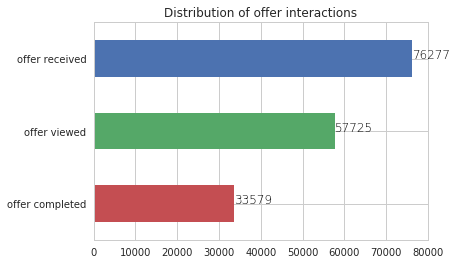

In [54]:
horizontal_bar_plot(merged_data, 'event', "Distribution of offer interactions")

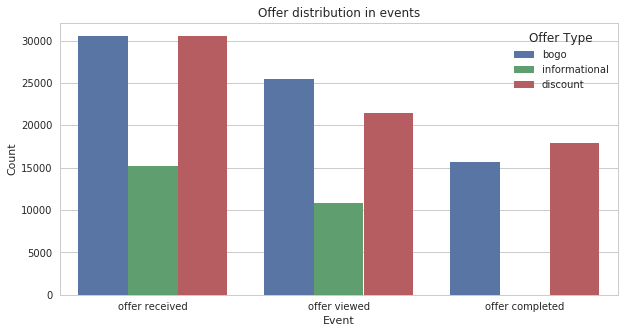

In [55]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_data)
sns.set(style="white")
plt.title('Offer distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

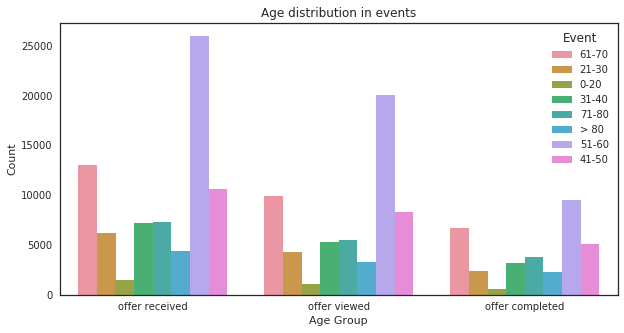

In [56]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "age_group", data=merged_data)
sns.set(style="whitegrid")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

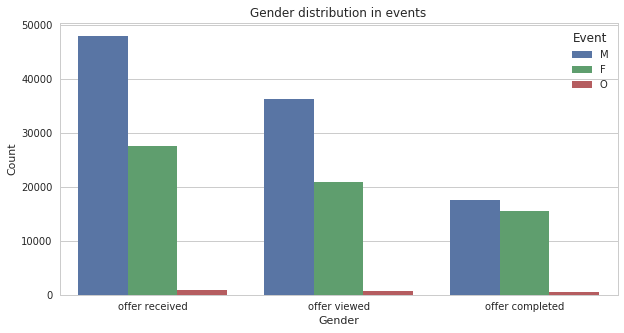

In [57]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "gender", data=merged_data)
sns.set(style="whitegrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Event')

### FINDINGS
=> The most offered offer types are **bogo** and **discount**  
=> There have been **76k offer received**, **58k viewed** and **34k completed**    
=> We can see, what is clear, the an informational offer can not be completed.  
=> **Discount** and **Bogo** offers were sent almost equally as often, with...     
=> **Bogo** offers being more often reviewed.  
=> The age distribution is even distributed across the different offer types.  
=> Looking at the ratio of received, reviewed and completed offers, **female members complete** more offers than do male

## Step 4 - Machine Learning Model
### (A) Prepare Data

In [58]:
merged_data.dtypes

channels                    object
offer_difficulty             int64
offer_duration               int64
offer_id                    object
offer_type                  object
offer_reward                 int64
event                       object
customer_id                 object
time                         int64
reward_gained              float64
amount_spent               float64
became_member_on    datetime64[ns]
gender                      object
customer_income            float64
age_group                   object
membership_year              int64
membership_month             int64
dtype: object

In [59]:
# In order to use the data in our ML Model we need to perform some preparation steps
# 1. Encode all categorical data
# 2. Encode event data to be numerical => in order to use it later
# 3. Normalize the data to makeo it useable

def merged_data_cleaning(df):

    # process categorical variables
    categorical = ['offer_type', 'gender', 'age_group']
    df = pd.get_dummies(df, columns = categorical)
    # process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    # process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    # process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    # process numerical variables and initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'reward_gained', 'amount_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    # encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    # drop column, since year and month have already been pulled out
    df.drop('became_member_on',axis=1, inplace=True)  
    
    return df

In [60]:
merged_data_clean = merged_data_cleaning(merged_data)
merged_data_clean.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,reward_gained,amount_spent,customer_income,...,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71-80,age_group_> 80,email,mobile,social,web
0,0.5,0.571429,0,1.0,1,0,0.000000,0.0,0.0,0.777778,...,0,0,0,1,0,0,1,1,1,0
1,0.5,0.571429,0,1.0,2,0,0.142857,0.0,0.0,0.777778,...,0,0,0,1,0,0,1,1,1,0
2,0.5,0.571429,0,1.0,1,0,0.705882,0.0,0.0,0.777778,...,0,0,0,1,0,0,1,1,1,0
3,0.5,0.571429,0,1.0,2,0,0.714286,0.0,0.0,0.777778,...,0,0,0,1,0,0,1,1,1,0
4,0.5,0.571429,0,1.0,3,0,0.714286,1.0,0.0,0.777778,...,0,0,0,1,0,0,1,1,1,0


In [61]:
merged_data_clean.dtypes

offer_difficulty            float64
offer_duration              float64
offer_id                      int64
offer_reward                float64
event                         int64
customer_id                   int64
time                        float64
reward_gained               float64
amount_spent                float64
customer_income             float64
membership_year               int64
membership_month              int64
offer_type_bogo               uint8
offer_type_discount           uint8
offer_type_informational      uint8
gender_F                      uint8
gender_M                      uint8
gender_O                      uint8
age_group_0-20                uint8
age_group_21-30               uint8
age_group_31-40               uint8
age_group_41-50               uint8
age_group_51-60               uint8
age_group_61-70               uint8
age_group_71-80               uint8
age_group_> 80                uint8
email                         int64
mobile                      

In [62]:
merged_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 30 columns):
offer_difficulty            167581 non-null float64
offer_duration              167581 non-null float64
offer_id                    167581 non-null int64
offer_reward                167581 non-null float64
event                       167581 non-null int64
customer_id                 167581 non-null int64
time                        167581 non-null float64
reward_gained               167581 non-null float64
amount_spent                167581 non-null float64
customer_income             167581 non-null float64
membership_year             167581 non-null int64
membership_month            167581 non-null int64
offer_type_bogo             167581 non-null uint8
offer_type_discount         167581 non-null uint8
offer_type_informational    167581 non-null uint8
gender_F                    167581 non-null uint8
gender_M                    167581 non-null uint8
gender_O                 

In [63]:
merged_data_clean.event.value_counts()

1    76277
2    57725
3    33579
Name: event, dtype: int64

In [64]:
merged_data_clean.columns

Index(['offer_difficulty', 'offer_duration', 'offer_id', 'offer_reward',
       'event', 'customer_id', 'time', 'reward_gained', 'amount_spent',
       'customer_income', 'membership_year', 'membership_month',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'gender_F', 'gender_M', 'gender_O', 'age_group_0-20', 'age_group_21-30',
       'age_group_31-40', 'age_group_41-50', 'age_group_51-60',
       'age_group_61-70', 'age_group_71-80', 'age_group_> 80', 'email',
       'mobile', 'social', 'web'],
      dtype='object')

### (B) Create Training and Test data split

In [65]:
# Drawing from experience, I will split the data in 80-20 (Train-Test).
ml_data = merged_data_clean.drop('event', axis=1)
label = merged_data_clean['event']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(ml_data, label, test_size = 0.2, random_state = 0)
print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 134064 rows
Testing set: 33517 rows


### (C) Training and Testing

In [67]:
# I will use the F1 score to measure the model quality and to assess which model to chose.
# The F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

def train_test(clf):

    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

### I will apply three different methods:  
the **k-nearest neighbors algorithm for classification**,  
the **random forest classification** and  
the **decision tree classification**  

#### (C.1) K-nearest neighbors algorithm for classification

In [68]:
C1 = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, C1_model = train_test(C1)

#### (C.2) RandomForestClassifier

In [69]:
C2 = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, C2_model = train_test(C2)

#### (C.3) DecisionTreeClassifier

In [84]:
C3 = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, C3_model = train_test(C3)

#### Summary

In [85]:
models = {'Method': [C1_model, C2_model, C3_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
summary = pd.DataFrame(models)
summary

,Method,train F1 score,test F1 score
0,KNeighborsClassifier,51.444832,28.854014
1,RandomForestClassifier,92.795232,66.539368
2,DecisionTreeClassifier,93.922306,84.977772


#### Optimization of Models using GridSearch

In [102]:
from sklearn.model_selection import GridSearchCV

#### (C.2) RandomForestClassifier - optimized

In [112]:
param_grid = {'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

In [89]:
C2_optimization = RandomForestClassifier(random_state = 10)

In [113]:
g_search_C2 = GridSearchCV(estimator = C2_optimization, param_grid = param_grid, 
                          cv = 3, n_jobs = 2, verbose = 0, return_train_score=True)

In [115]:
g_search_C2.fit(X_train, y_train);
print(g_search_C2.best_params_)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 13}


In [116]:
C2_optimized = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='auto', n_estimators=13)
b2_train_f1, b2_test_f1, C2_opt_model = train_test(C2_optimized)

#### (C.3) DecisionTreeClassifier - optimized

In [118]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}

In [119]:
C3_optimization = DecisionTreeClassifier(random_state = 10)

In [120]:
g_search_C3 = GridSearchCV(estimator = C3_optimization, param_grid = param_grid, 
                          cv = 3, n_jobs = 2, verbose = 0, return_train_score=True)

In [121]:
g_search_C3.fit(X_train, y_train);
print(g_search_C3.best_params_)

{'criterion': 'entropy', 'max_depth': 12}


In [126]:
C3_optimized = DecisionTreeClassifier(criterion='entropy', max_depth=12)
c2_train_f1, c2_test_f1, C3_opt_model = train_test(C3_optimized)

#### Summary

In [127]:
models = {'Method': [C1_model, C2_model, C3_model, "optimized Models below",  C2_opt_model, C3_opt_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1, "-", b2_train_f1, c2_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1, "-", b2_test_f1, c2_test_f1] }
          
summary = pd.DataFrame(models)
summary

,Method,train F1 score,test F1 score
0,KNeighborsClassifier,51.4448,28.854
1,RandomForestClassifier,74.1907,73.2136
2,DecisionTreeClassifier,93.9223,84.9778
3,optimized Models below,-,-
4,RandomForestClassifier,75.282,73.9296
5,DecisionTreeClassifier,92.3522,92.3531


## Step 5 - Conclusion

In order to investigate the different data sets and discuss possible problems and there solutions, I first had to cleand and prepare the seperate data sets. Unfortunately I showed, that there were many NaN entry; an issue the I resolved with replacing the NaN with average or mode values. This lead to more data, however one could argue, that the replacement approach brings also potential issues regarding the validty. Since dropping the NaN data would have reduced the data set to and extend that seemed to substantial, I chose - knowing all the risks - to use the above mentioned replacement options.  

The next steps included merging the data, lookig at it with a classic EDA approach as well as build a simple ML model.  

The results are summarized and discussed below.

## (1) EDA

### FINDINGS - (B) What is the averge income?  
=> The average income is **66301**  
=> The median income is **65405**  
=> We can not observe a normal distribution  
=> Most incomes range between **52k and 78k** 

### FINDINGS - (C) What do we know about age and gender distribution?
=> The dataset contains almost **40k** more men than women  
=> Most members are between **51** and **60**, with **61** to **70** being in second place   
=> The biggest membership group according to age (51-60) is dominated by **male** members  
=> Most new memberships were signed in **2017** followed by **2018** with a overrepresentation of male members   
=> Most new memberships were signed in **January & August through October**  

### FINDINGS - (D) What do we know about the offers in combination with prior investigatons?
=> The most offered offer types are **bogo** and **discount**  
=> There have been **76k offer received**, **58k viewed** and **34k completed**    
=> We can see, what is clear, the an informational offer can not be completed.  
=> **Discount** and **Bogo** offers were sent almost equally as often, with...     
=> **Bogo** offers being more often reviewed.  
=> The age distribution is even distributed across the different offer types.  
=> Looking at the ratio of received, reviewed and completed offers, **female members complete** more offers than do male

### SUMMARY
1. Most members are male between the age of 51-70.  
2. Most new memberships are sigend in January & August through October.  
3. Most incomes range between 52k and 78k.  
4. Bogo offers are most often reviewed.  
5. Female members complete more offers than male members.  

As a conclusion from the EDA I would suggest the following steps in order to address two different scenarios:  

**Scenario 1**: In order to increase the members I would suggest to reach out to females below the age of 51. This would expand the not yet addressed customer base and create are more homogeneous member distribution accross the population.  

**Scenario 2**: In order to increase the usage of offer types, I would suggest to send even more Bogo offers to males as well as use informational offers to increase the awarness of Bogo offers. If the male bogo conversion would, even only slightly move towards the female one, it would massively increase the overall offer-sent-to-completed ratio.   

## (2) ML
### SUMMARY

In order to solve the problem of how to predict whether a customer (member) is completing a offer or not, I applied three differen ml model.  

It is obvious that the RandomForest and DecisionTree are the better models, with the DT performing better in both, training and test F1 scores. I would have liked to see test F1 scores even closer to 100, but 85 seems high enough to apply the DT model in the future. 

Further steps should include:  
1. Validate whether the F1 score is the one to meassure the models with, since Precision is important, but Sensitivity (Recall) not as much in our case. We could therefore change the metric to determin the best model.  
2. Can we get more data about the customer. Age, gender and income are all valid information, but not really enough to dig deeper into why someone would react to a specific offer in a certain way.

In [72]:
models = {'Method': [C1_model, C2_model, C3_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
summary = pd.DataFrame(models)
summary

,Method,train F1 score,test F1 score
0,KNeighborsClassifier,51.444832,28.854014
1,RandomForestClassifier,92.795232,66.539368
2,DecisionTreeClassifier,93.922306,84.977772
